# Part I : Quel(le) data scientist êtes-vous ?
## Contexte de l’analyse

Elu métier le plus sexy par la Harvard Business Review en octobre 2012, le data scientist représente un profil rare qui exige de nombreuses compétences.

A partir d'un dataset Aquila, vous réaliserez :
- un clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
- une prédiction des profils dont le métier n'est pas labellisé


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
    


## Répondez aux questions 

Bonne chance!

In [1]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sb
from matplotlib import pyplot as plt
from sklearn.metrics  import *
%matplotlib inline
plt.style.use('ggplot')


### 1) Importer le tableau de données dans un dataframe 

In [2]:
# Avoir un apercu des donnees, detecter le separateur
# et le caractere utilise pour les virgules
ligne_a_lire = 6
with open('data.csv','r') as file:
    for i in range(ligne_a_lire):
        print(file.readline())

Entreprise,Metier,Technologies,Diplome,Experience,Ville

Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris

Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille

Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-learn,Master,3,Nantes

Ann & Robert H. Lurie Children’s Hospital of Chicago,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille

Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,,Bordeaux



Le separateur de columne ici est une <b>','</b>. Nous allons l'utiliser avec pandas 

In [3]:
# Import du dataframe "data.csv"
filename = 'data.csv'
df = pd.read_csv(filename, sep=',', decimal=',')

In [4]:
# Avoir un apercu des premieres lignes du fichier
nombre_lignes_a_visualiser = 5
df.head(nombre_lignes_a_visualiser)

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


### 2) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes? 

In [5]:
# methode 1 : avec shape
# methode 2 : avec len
print(' methode 1: nombre d\'observations du dataset {} \n'.format(df.shape[0]))
print(' methode 2: nombre d\'observations du dataset {} \n'.format(len(df)))


 methode 1: nombre d'observations du dataset 9582 

 methode 2: nombre d'observations du dataset 9582 



In [6]:
## Apercu des valeurs manquantes
## Calculons la proportion de valeurs manquantes dans chacune des columnes
print('proportion des valeurs manquantes dans chacune des columnes en %: \n')
print(df.isnull().mean()*100)

proportion des valeurs manquantes dans chacune des columnes en %: 

Entreprise      0.177416
Metier          0.198288
Technologies    0.000000
Diplome         0.000000
Experience      0.981006
Ville           0.000000
dtype: float64


<br> Concernant les valeurs manquantes, je constate que les variables categorielles <b> Entreprise</b>, <b>Metier</b> en contiennent approximativement et respectivement <b>0.17%</b> et <b>0.18%</b> tandis que la variable numerique <b>Experience</b> en contient moins de <b>1%</b>.
<br> Ces donnees manquantes sont assez rares (moins de 1%) en general, le dataset est donc exploitable et on peut remplacer ces valeurs manquantes par diverses méthodes (moyenne, medianne, mode (pour les variables categorielles)

### 3) Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec : 
- la valeur médiane pour les data scientists
- la valeur moyenne pour les data engineers

In [7]:
def making_imputation(dataframe, column, value, method):
    '''
    INPUT
    -dataframe: dataframe where we did imputation
    -column: columnn where we realize imputation
    - value: value in column to replace
    - method : method of imputation
    OUTPUT
    - return new dataframe with replaced values
    
    '''
    dataset = dataframe.copy()
    assert value in dataframe[column].value_counts(), 'value not in column'
    index_column = list(dataset[dataset[column].isin([value])].\
                        isnull().index.values)
    if method=='mean':
        dataset.loc[index_column, 'Experience'] = df.loc[index_column,'Experience'].\
                                            transform(lambda col:col.fillna(col.mean()))
    if method=='median':
        dataset.loc[index_column, 'Experience'] = df.loc[index_column,'Experience'].\
                                            transform(lambda col:col.fillna(col.median()))
    if method=='mode':
        assert np.issubdtype(dataset.column, np.number), 'variable non categorielle'
        dataset.loc[index_column, 'Experience'] = df.loc[index_column,'Experience'].\
                                            transform(lambda col:col.fillna(col.mode()))
    return dataset

## Remplacer les valeurs manquantes pour les data scientists par la valeur mediane
df = making_imputation(df, 'Metier', 'Data scientist', 'median')
## Remplacer les valeurs manquantes pour les data engineers par la moyenne
df = making_imputation(df, 'Metier', 'Data engineer', 'mean')

La méthode que j'ai employee ici, consiste d'abord a detecter <b> les indices </b> du dataset correspondant aux differents emplois qu'on recherche ici, à savoir <b> data scientist </b> et <b> data engineers </b>.
<br> Ensuite nous allons proceder à la modification des <b> NaN </b> presents à ces ligne par les valeurs demandées.
<br> <b> Il existe surement des méthodes plus optimisées mais celle la me parait pas, j'aurai le temps de reflechir à d'autres méthodes et calculer la plus rapide </b>

### 4) Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne?

In [8]:
# Calcul des annees d'experiences de chacun des profils
print('Moyenne des experiences des differents metiers \n {}'.\
      format(df.groupby('Metier')['Experience'].mean()))


Moyenne des experiences des differents metiers 
 Metier
Data architecte        3.000476
Data engineer          2.984959
Data scientist         2.241268
Lead data scientist    3.965261
Name: Experience, dtype: float64


<b> Le data scientist </b> a en moyenne <b>3.0 annees </b> d'experiences. <br>
<b> Le lead data scientist </b> a en moyenne <b>3.96 annees </b> d'experiences. <br>
<b> Le data engineer </b> a en moyenne <b>2.98 annees </b> d'experiences.

### 5) Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

Text(0.5,1,"Annee d'experience de divers acteurs de la data")

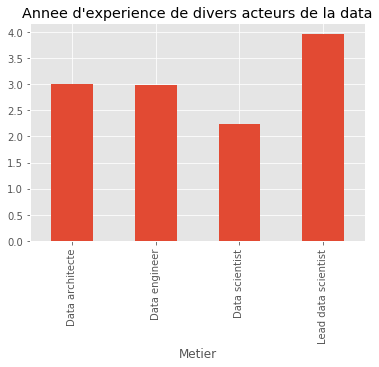

In [9]:
df.groupby('Metier')['Experience'].mean().plot(kind='bar')
plt.title('Annee d\'experience de divers acteurs de la data')

### 6) Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert
- Veuillez expliquer votre choix du règle de transformation.  

Verifions s'il reste encore des <b>NaN</b> dans la variable <b>Experience</b>

In [10]:
#Verifions s'il reste encore des NaN dans experience
df.isnull().mean()*100

Entreprise      0.177416
Metier          0.198288
Technologies    0.000000
Diplome         0.000000
Experience      0.438322
Ville           0.000000
dtype: float64

Il reste encore 0.43% de NaN dans experience, certainement du aux valeurs dans Lead data scientist et lead architect qu'on a pas modifié.
<br> Afin de transformer la variable categorielle, nous allons aussi proceder à l'imputation de ces NaN avec
la mediane, plus robuste aux valeurs abberantes

In [11]:
## Remplacer les valeurs manquantes pour les data architectes par la valeur mediane
df = making_imputation(df, 'Metier', 'Lead data scientist', 'median')
## Remplacer les valeurs manquantes pour les lead data scientist par la moyenne
df = making_imputation(df, 'Metier', 'Data architecte', 'median')

<b> Explication de la methode de transformation </b>

La categorisation d'une variabe continue s'accomapagne toujours d'une perte d'informations mais elle peut accelerer et ameliorer la classification.
<br> J'envisageais deux methodes, en utilisant les fonctions <b>cut</b> et <b>qcut</b>.
<br> La fonction qcut est base sur les quantiles et subdivise la variable continue en clusters irregulierement espacé mais contenant a peu près le meme nombre d'individu, ce qui n'est pas très réaliste.
<br> La méthode cut quant à elle créer des clusters successifs mais ne contenant pas forcement le meme nombre d'individus. Cette méthode nous parait plus réaliste.
<br> J'aurai pu partir sur une consideration métier basé sur mes connaissances à priori mais je prefère cette méthode.

In [18]:
### Realisons ala categorisation avec la methode cut
df['Exp_label'] = pd.cut(df.Experience, bins=4,\
                         labels=["debutant", "confirme", "avance", "expert"])

In [19]:
df

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris,debutant
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille,debutant
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes,debutant
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille,debutant
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.0,Bordeaux,debutant
5,S&P Global Ratings,Lead data scientist,VBA/Python/Excel/R,Master,6.0,Lille,confirme
6,NVIDIA,Data scientist,Excel/VBA/R/Python/PySpark,Bachelor,0.0,Lille,debutant
7,Cedars-Sinai Medical Center,Data scientist,Java/C/C++/R/Python,Bachelor,4.0,Toulouse,debutant
8,Fibroblast,Data architecte,Java/Linux/Docker,Bachelor,8.0,Paris,confirme
9,General Motors,Data engineer,Python/Java/Linux/GNU,Master,5.0,Toulouse,debutant


Ayons un apercu des intervalles crees

In [24]:
pd.cut(df.Experience, 4, retbins=True)


(0       (-0.021, 5.25]
 1       (-0.021, 5.25]
 2       (-0.021, 5.25]
 3       (-0.021, 5.25]
 4       (-0.021, 5.25]
 5         (5.25, 10.5]
 6       (-0.021, 5.25]
 7       (-0.021, 5.25]
 8         (5.25, 10.5]
 9       (-0.021, 5.25]
 10      (-0.021, 5.25]
 11      (-0.021, 5.25]
 12      (-0.021, 5.25]
 13      (-0.021, 5.25]
 14      (-0.021, 5.25]
 15      (-0.021, 5.25]
 16      (-0.021, 5.25]
 17      (-0.021, 5.25]
 18      (-0.021, 5.25]
 19        (5.25, 10.5]
 20      (-0.021, 5.25]
 21      (-0.021, 5.25]
 22      (-0.021, 5.25]
 23      (-0.021, 5.25]
 24      (-0.021, 5.25]
 25        (5.25, 10.5]
 26        (5.25, 10.5]
 27      (-0.021, 5.25]
 28      (-0.021, 5.25]
 29        (5.25, 10.5]
              ...      
 9552    (-0.021, 5.25]
 9553      (5.25, 10.5]
 9554    (-0.021, 5.25]
 9555    (-0.021, 5.25]
 9556    (-0.021, 5.25]
 9557      (5.25, 10.5]
 9558    (-0.021, 5.25]
 9559     (15.75, 21.0]
 9560    (-0.021, 5.25]
 9561    (-0.021, 5.25]
 9562    (-0.021

Les differentes categories crees sont:
<br> <b>Debutant</b> [0 5.25], <br> <b>Confirme</b> ]5.25 10.5], <br> <b>Avance</b> ]10.5 15.75] <br> <b>Avance</b> ]15.75 21.0]

Text(0.5,1,'repartition des categories')

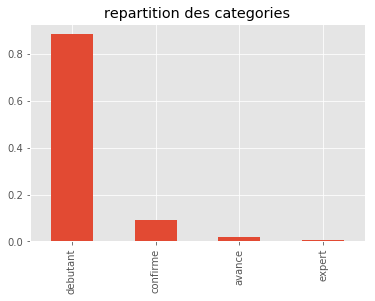

In [29]:
(df.Exp_label.value_counts()/df.shape[0]).plot(kind="bar")
plt.title('repartition des categories')

### 7) Quelles sont les 5 technologies les plus utilisées? Faites un graphique

Listons l'ensemble des technologies utilisées par l'ensemble des candidats

In [39]:
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label,Exp_label_2
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris,debutant,0
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille,debutant,0
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes,debutant,0
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille,debutant,0
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.0,Bordeaux,debutant,0


Regardons si sur chaque ligne, chaque observation ne contient pas une technoogie en double ce qui peut fausser le calcul du decompte.
<br> On se sert de set pour faire le compte des technoogies uniques et nous verifions si ce compte est egale à celle de la liste de depart si oui il n'ya pas de double sinon il y'en a

In [41]:
#Regardons s'il n'ya pas de technologies repetitives sur chaque ligne
test_ligne = list(map(lambda x:len(set(x.split('/')))==len(x.split('/')), df.Technologies))

In [43]:
all(test_ligne)

True

In [38]:
# Listons l'ensemble des technologies utilisees
technologies_utilisees = list(map(lambda x:x.split('/'), df.Technologies))
# Mettons à plat (nested) la liste de liste obtenu precedemment
liste_des_logiciels_utilises = [val.lower() for sublist in technologies_utilisees
                                for val in sublist if len(val)!=0]

# Stockons la liste unique des logiciels utilises
liste_unique_des_logiciels_utilises = list(set(liste_des_logiciels_utilises))

In [44]:
a = [True, False]
all(a)

False

In [35]:
liste_unique_des_logiciels_utilises

['java',
 'hadoop(hdfs)',
 'mongodb',
 'postgresql',
 'perl',
 'nosql',
 'pycharm',
 'matplotlib',
 'pyspark',
 'r',
 'spss',
 'vba',
 'elasticsearch',
 'windows',
 'deep learning',
 'mysql',
 'sql',
 'scikit-learn',
 'c++',
 'scala',
 'kibana',
 'matlab',
 'excel',
 'oracle',
 'tensorflow',
 'microsoft azure',
 'python',
 'yarn',
 'c',
 'machine learning',
 'hive',
 'teradata',
 'nosq',
 'gnu',
 'redshift',
 'numpy',
 'ruby',
 'cassandra',
 'anglais',
 'ai',
 'mariadb',
 'docker',
 'kafka',
 'spark',
 'hbase',
 'aws',
 'sas',
 'map-reduce',
 'linux',
 'vertica',
 'hadoop',
 'hdfs',
 'tableau',
 'pig',
 'big data',
 'scoring']

La liste unique des logiciels nous montre des elements repetititifs ecrit sous differentes formes
comme <b>hadoop(hdfs)</b> et <b>hadoop</b>.
<br> La mise en minuscule des technologies utilises a permis d'eliminer les redondances lies a l'emploi de majuscule type <b> Machine learning </b> et <b> machine learning </b>. Il est aussi utile de noter que l'anglais n'est pas une technologie mais une langue, on peut donc la retirer de notre decompte.
<br> numpy, matplotlib, tensorflow sont des librairies pythons mais des technologies à part entière. Que signifie alors donc maitriser python? cela englobe t'il le tout? ou cela signifie simplement maitriser les basiques mais comment faire de la data science avec python sans ces outils? 
python reste neanmoins une technologie que l'on conserveras.
<br> Aussi machine learning, deep learning, big data, map-reduce et scoring ne semblent pas être des technologies mais des domaines ou des technologies sont employés.

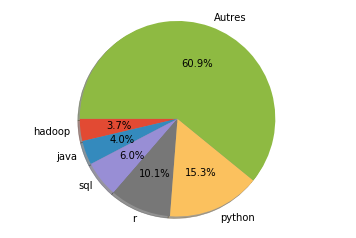

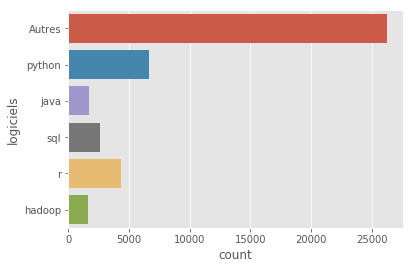

In [37]:
# Nombre des N technologies desirees
liste_n_largest = 5
# Stockons dans une liste le nombre
sizes = [liste_des_logiciels_utilises.count(elt) for elt in liste_unique_des_logiciels_utilises]
# Avoir les index des N technologies les plus utilisees
index = np.argsort(sizes)[-liste_n_largest:]
# Avoir les noms de ces technologies
labels = np.asarray(liste_unique_des_logiciels_utilises, dtype=str)
labels = list(labels[index])
# Regrouper toutes les autres technologies dans une grosse categorie appelee Autres
labels2 = labels
labels.append ('Autres') #rajouter les autres qu'on a pas comptabiliser
sizes2 =np.asarray(sizes)[index]
sizes2 = list(sizes2)
sizes2.append(len(liste_des_logiciels_utilises)-sum(sizes2)) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes2, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=180)
ax1.axis('equal')
plt.plot('camembert des logiciels utilises')
plt.show()

##### je vois l'iddee
liste_des_logiciels_utilises2 = np.asarray(liste_des_logiciels_utilises)  
liste_des_logiciels_utilises2[~np.isin(liste_des_logiciels_utilises2, labels2)] = 'Autres'   
data2 = pd.DataFrame(data=liste_des_logiciels_utilises2, columns=['logiciels'])
ax = sb.countplot( y='logiciels', data= data2)

Conclusion <br>Comme on peut le constater sur le camembert, <br> Python vient en première position des languages utilisés  par les personnes de la data avec un score de <b>15.3%</b>, suivi de près par le langage R, prisée des statisticiens <b>10.0%</b>, Ensuite viennent des outils de gestion, de gestion de la donnee comme SQL <b>5.9%</b>, Hadoop <b>3.6%</b>. <br> Java lui est moins utilisé comparé à Python et R, cela peut être lié au fait que les outils orientés Machine Learning sont plus rares ou moins vulgarisés (prisés)
<br> On constate aussi que des mots comme Anglais sont presents dans les technologies et il existe plusieurs denominations du meme outil comme Spark (pyspark). Aussi, des technologies mentionnees matplotlib et scikit learn font partie de python qui lui meme est mentionne. Nous avons reglé le probleme de la denomination du meme logiciel <br>exemple:  Hadoop et hadoop </br> en mettant en miniscule le nom des technologies.
<br> En conclusion, il y'a beaucoup de redondances d'informations. Afin d'effectuer une classification ou une possible regression, nous allons proceder a une reduction de la dimensionnalité du dataset

In [ ]:
liste_des_logiciels_utilises2

### 8) Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître 2 clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

### Categoriser les technolgies via le one hot encodeur

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
software_maitrise = pd.DataFrame(mlb.fit_transform(df.Technologies.str.split('/')),columns=mlb.classes_, index=df.index)
software_maitrise = software_maitrise.drop('',axis=1)#element non desire issu du split
#software_maitrise = np.asarray(software_maitrise)

In [ ]:
software_maitrise.columns

Il s'agira ici de remplacer toute les variables categorielles par des variables numeriques avec le one hot encoding. 
On peut supprimer la variable metier pour cette etude, par ce que le metier correspont approximativement a une certaine categorie de competences techniques plus ou moins defini, l'entreprise aussi ne semble pas être une variable pertinente, de meme que la ville ou l'emploi est effectué
Le nombre d annee d experience peut definir un profil technique on va get dummies la variable cree

In [ ]:
software_maitrise

In [ ]:
job_experiences = np.asarray(pd.get_dummies(df.Exp_label))
diplomes = np.asarray(pd.get_dummies(df.Diplome))
metiers = np.asarray(pd.get)

In [ ]:
dataset_of_clustering = np.concatenate((software_maitrise, job_experiences, diplomes), axis=1)

### Reduction de la dimensionnalite concernant les technologies

In [ ]:
from sklearn.decomposition import TruncatedSVD

percentage_variance_explained = []
for elt in range(1,dataset_of_clustering.shape[1]):
    tsvd = TruncatedSVD(n_components=elt)
    X =  tsvd.fit(dataset_of_clustering).transform(dataset_of_clustering)
    percentage_variance_explained.append(tsvd.explained_variance_ratio_[0:elt].sum())
 
plt.plot(list(range(1, dataset_of_clustering.shape[1])), percentage_variance_explained)

In [ ]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=40)
software_maitrise_to_take =  tsvd.fit(dataset_of_clustering).transform(dataset_of_clustering)
print('pourcentage explique {} \n'.format(tsvd.explained_variance_ratio_[0:40].sum()))
 

In [ ]:
from sklearn import metrics
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [ ]:
dataset_of_clustering

In [ ]:
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=100)
kmeans.fit(dataset_of_clustering)
preds = kmeans.fit_predict(dataset_of_clustering)

In [ ]:
clustering = AgglomerativeClustering()
clustering.fit(dataset_of_clustering)

In [ ]:
clustering_validity = silhouette_score(dataset_of_clustering, preds)

In [ ]:
clustering_validity

In [ ]:
df['kmean_label'] = kmeans.labels_
df['agglo_label'] = clustering.labels_

In [ ]:
df.head()

### 9) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

In [ ]:
metiers_pas_renseigne = df[pd.isnull(df.Metier)].reset_index()


In [ ]:
dataset_base = df.dropna(subset=['Metier'], how='all')

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)


In [ ]:
train_set

### 10) Décrire de façon détaillée les différentes étapes pour mener à bien un projet data complexe.

Dans le cadre d’une campagne de recrutement vous avez reçu un ensemble de cv qui ne sont pas à jour (le poste actuel n’est pas présent). Deux exemple de CV vous sont donnés en pièce jointe (il n'y a pas de mise en page type). Tous les CV sont au format PDF.

On souhaite connaitre le poste actuel de chaque candidat.

-  Quelles sont les différentes étapes nécessaires à la réalisation d'un tel projet?
-  Pour chaque étape, détaillez les taches à accomplir, les méthodes à suivre, les pistes possibles, les points critiques.
-  Justifiez consciencieusement vos choix
